# Multi-Layer Perceptron

## Importation librairies

In [1]:
import numpy as np

from tensorflow.keras.utils import normalize, plot_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy

import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

2024-06-02 20:55:35.902158: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 20:55:35.904043: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 20:55:35.931911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 20:55:35.931936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 20:55:35.932581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Data import and display

health: -1.0
[ 0.50205548  0.54216265  0.72238348  1.4288852   2.1365158   2.281149
  1.9362737   1.46889     1.0088451   0.38028224 -0.29677967 -0.51392868
 -0.25564469 -0.10720254 -0.28782655 -0.41800901 -0.31916313 -0.2603787
 -0.35035721 -0.50548599 -0.71088709 -0.82391982 -0.89970154 -1.1539497
 -1.2298306  -1.044091   -1.2020312  -1.3921949  -1.1301083  -1.1798666
 -1.6492718  -1.7265754  -1.6083704  -1.6628022  -1.6506724  -1.6973094
 -1.8386968  -1.8025962  -1.7805361  -1.8251665  -1.6447633  -1.4238097
 -1.3921949  -1.3604156  -1.2001781  -0.91863234 -0.68591581 -0.66794346
 -0.51272154 -0.10169069  0.06395426  0.08261431  0.23760718  0.17479318
  0.12320539  0.5033942   0.6838702   0.47499476  0.53279711  0.72354995
  0.6644198   0.64793559  0.75705403  0.7320716   0.62021499  0.60629677
  0.67795016  0.68908363  0.59880728  0.54264656  0.58180737  0.63063068
  0.6644198   0.6863178   0.65738251  0.65088944  0.72173837  0.73970645
  0.69148052  0.69522947  0.7501145   0.85384

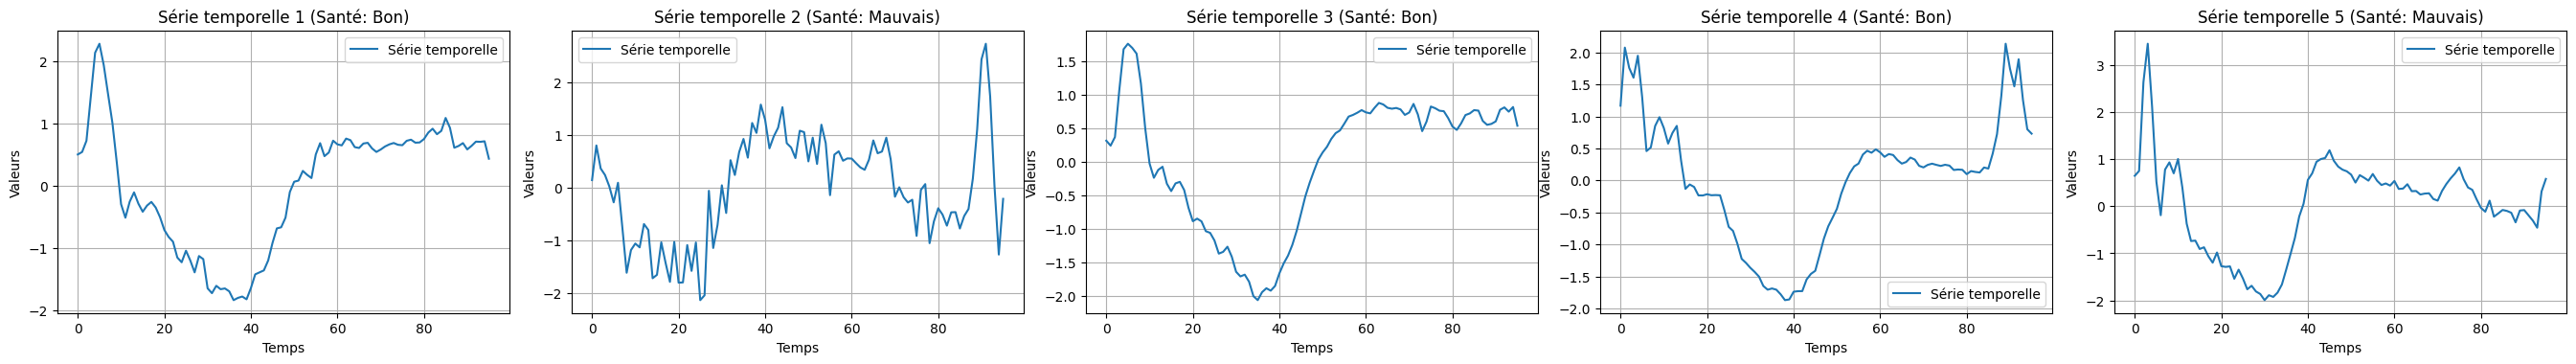

In [2]:
# Data recovery
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

# Show first time series
print("health:", train_data[0,0])
print(train_data[0,1:])

# Show data dimensions
print("Dimensions des données d'entrainnement:", train_data.shape)
print("Dimensions des données de test:", test_data.shape)

# Show first 5 time series
nb_series_a_afficher = 5
plt.figure(figsize=(27, 7))
for i in range(nb_series_a_afficher):
    serie_temporelle = train_data[i, 1:]
    etat_sante = train_data[i, 0]
    
    plage_temps = range(len(serie_temporelle))
    
    plt.subplot(2, nb_series_a_afficher, i+1)
    plt.plot(plage_temps, serie_temporelle, label='Série temporelle')
    plt.xlabel('Temps')
    plt.ylabel('Valeurs')
    plt.title(f'Série temporelle {i+1} (Santé: {"Bon" if etat_sante == -1 else "Mauvais"})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Data processing

In [3]:
# Normalizer les classe
train_data[train_data[:, 0] == -1, 0] = 0
test_data[test_data[:, 0] == -1, 0] = 0

# Separation of training and testing data
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# Normalize time series between 0 and 1 independently of each other
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

# Display first data
print("health:", y_train[0])
print(X_train[0])
print("Dimensions des données d'entrainnement:", (X_train.shape, y_train.shape))

health: 0.0
[ 0.05150981  0.05562471  0.07411498  0.14660053  0.2192019   0.23404095
  0.19865749  0.15070493  0.10350532  0.03901613 -0.03044895 -0.05272797
 -0.02622859 -0.01099875 -0.02953038 -0.04288682 -0.03274545 -0.02671429
 -0.03594589 -0.05186177 -0.07293548 -0.08453239 -0.09230743 -0.11839274
 -0.12617796 -0.10712148 -0.1233258  -0.14283618 -0.11594667 -0.12105176
 -0.16921172 -0.1771429  -0.16501532 -0.17059991 -0.16935542 -0.17414027
 -0.18864631 -0.18494247 -0.18267915 -0.18725813 -0.16874915 -0.14607979
 -0.14283618 -0.1395757  -0.12313568 -0.09424969 -0.07037348 -0.06852955
 -0.05260412 -0.01043324  0.00656157  0.00847605  0.02437798  0.0179334
  0.01264061  0.05164716  0.0701636   0.04873343  0.05466383  0.07423466
  0.06816803  0.06647679  0.0776721   0.07510896  0.06363272  0.06220474
  0.06955622  0.07069849  0.06143633  0.05567436  0.05969218  0.06470134
  0.06816803  0.07041472  0.06744602  0.06677985  0.07404879  0.07589228
  0.0709444   0.07132904  0.07696012  0.

## Choice of Hyperparameters

In [4]:
# Layers hyperparameters
nb_neurons = 512
hidden_activation = 'relu'
dropout = 0.2
nb_classes = 1
final_activation = 'sigmoid'

# Compil hyperparameters
learning_rate = 0.001
optimizer_algo = Adam(learning_rate=learning_rate)
cost_function = 'binary_crossentropy'

# Execution hyperparameters
nb_epochs = 150
mini_batch_size = 16
percentage_of_train_as_validation = 0.2

2024-06-02 20:55:38.231213: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Creating the model

In [5]:
# Input
input_shape = (96, )
input_layer = Input(input_shape)

# Hidden block
hidden_layer_1 = Dense(units=nb_neurons, activation=hidden_activation)(input_layer)
dropout_1 = Dropout(rate=dropout)(hidden_layer_1)

# Output
output_layer = Dense(units=nb_classes, activation=final_activation)(dropout_1)

model_mlp = models.Model(inputs=input_layer, outputs=output_layer)

## Model compilation

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96)]              0         
                                                                 
 dense (Dense)               (None, 512)               49664     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 50177 (196.00 KB)
Trainable params: 50177 (196.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


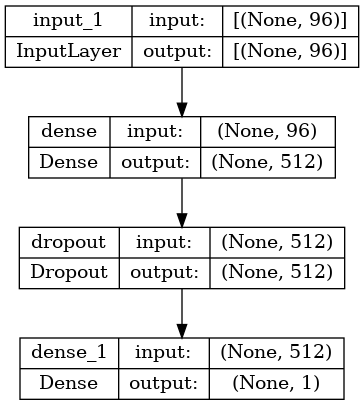

In [6]:
model_mlp.compile(loss=cost_function, optimizer=optimizer_algo, metrics=['accuracy'])

model_mlp.summary()
plot_model(model_mlp, show_shapes=True)

## Model training

In [7]:
# Specify the model checkpoint (to save the best model for each epoch)
model_checkpoint = callbacks.ModelCheckpoint('best_model_MLP.keras', monitor='val_loss', save_best_only=True)

# Start training
start_training = time.time()
history = model_mlp.fit(X_train, y_train,
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])
end_training = time.time()

## Model evaluation

In [8]:
# Load and evaluate best model
best_model_mlp = models.load_model('best_model_MLP.keras')

train_loss, train_accuracy = best_model_mlp.evaluate(X_train, y_train)

start_evaluate = time.time()
test_loss, test_accuracy = best_model_mlp.evaluate(X_test, y_test)
end_evaluate = time.time()


# Other calcul
y_pred = model_mlp.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_names = ['Positif', 'Négatif']
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

4/4 [==============================] - 0s 1ms/step


## Plot best result


Nombre total de paramètres : 50177

Temps d'entraînement : 4.264 secondes.
Temps d'évaluation : 0.044 secondes.

Moyenne de train_accuracy_vals: 96.00%
Moyenne de train_loss_vals: 10.32%

Moyenne de test_accuracy_vals: 85.00%
Moyenne de test_loss_vals: 41.87%

AUC-ROC :  0.9379340277777778


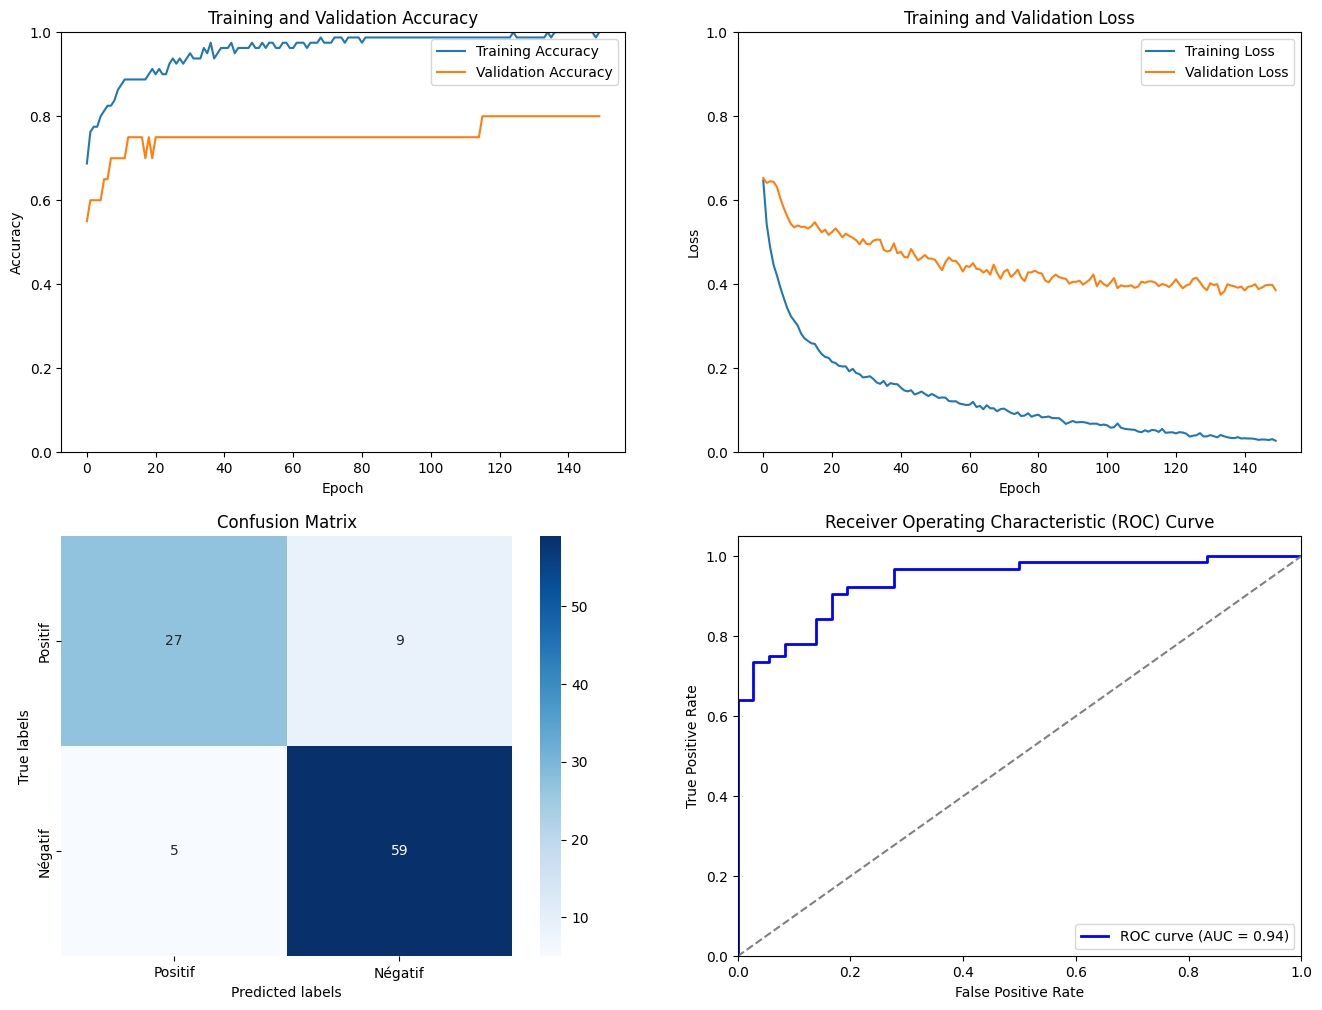

In [10]:
# Result
training_time_seconds = end_training - start_training
evaluate_time_seconds = end_evaluate - start_evaluate
print(f"\nNombre total de paramètres : {best_model_mlp.count_params()}")
print(f"\nTemps d'entraînement : {training_time_seconds:.3f} secondes.")
print(f"Temps d'évaluation : {evaluate_time_seconds:.3f} secondes.")
print(f'\nMoyenne de train_accuracy_vals: {np.mean(train_accuracy) * 100:.2f}%')
print(f'Moyenne de train_loss_vals: {np.mean(train_loss) * 100:.2f}%')
print(f'\nMoyenne de test_accuracy_vals: {np.mean(test_accuracy) * 100:.2f}%')
print(f'Moyenne de test_loss_vals: {np.mean(test_loss) * 100:.2f}%')
print(f'\nAUC-ROC : {roc_auc * 100:.2f}%')

# Plot 
plt.figure(figsize=(16, 12))
    # Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
    # Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
    # Confusion Matrix
plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
    # ROC Curve
plt.subplot(2, 2, 4)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Cross-validation

In [12]:
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

test_data[test_data[:, 0] == -1, 0] = 0
X_test, y_test = test_data[:, 1:], test_data[:, 0]
X_test = normalize(X_test, axis=1)

# Hyperparameters
nb_neurons = 512
hidden_activation = 'relu'
dropout = 0.2
nb_classes = 1
final_activation = 'sigmoid'
learning_rate = 0.001
optimizer_algo = legacy.Adam(learning_rate=learning_rate)
cost_function = 'binary_crossentropy'
nb_epochs = 150
mini_batch_size = 16
percentage_of_train_as_validation = 0.2

num_splits = 5
test_accuracy_vals = []
test_loss_vals = []
train_accuracy_vals = []
train_loss_vals = []

for i in range(num_splits) :
    train_data_suffled = train_data
    np.random.shuffle(train_data_suffled)
    train_data_suffled[train_data_suffled[:, 0] == -1, 0] = 0
    X_train, y_train = train_data_suffled[:, 1:], train_data_suffled[:, 0]
    X_trai = normalize(X_train, axis=1)

    # build and compil model
    input_shape = (96, )
    input_layer = Input(input_shape)
    hidden_layer_1 = Dense(units=nb_neurons, activation=hidden_activation)(input_layer)
    dropout_1 = Dropout(rate=dropout)(hidden_layer_1)
    output_layer = Dense(units=nb_classes, activation=final_activation)(dropout_1)
    model_mlp = models.Model(inputs=input_layer, outputs=output_layer)
    model_mlp.compile(loss=cost_function, optimizer=optimizer_algo, metrics=['accuracy'])

    model_checkpoint = callbacks.ModelCheckpoint('best_model_MLP.keras', monitor='val_loss', save_best_only=True)

    history = model_mlp.fit(X_train, y_train,
                        batch_size=mini_batch_size, 
                        epochs=nb_epochs,
                        validation_split=percentage_of_train_as_validation,
                        verbose=False,
                        callbacks=[model_checkpoint])

    # evaluate best model
    best_model_mlp = models.load_model('best_model_MLP.keras')
    train_loss, train_accuracy = best_model_mlp.evaluate(X_train, y_train)
    test_loss, test_accuracy = best_model_mlp.evaluate(X_test, y_test)

    test_accuracy_vals.append(test_accuracy)
    test_loss_vals.append(test_loss)
    train_accuracy_vals.append(train_accuracy)
    train_loss_vals.append(train_loss)

# Display result

# Calcul de la précision pour les données
print("\nNombre d'essais :", num_splits)
print(f'\nMoyenne de train_accuracy_vals: {np.mean(train_accuracy_vals) * 100:.2f}%')
print(f'Moyenne de train_loss_vals: {np.mean(train_loss_vals) * 100:.2f}%')
print(f'\nMoyenne de test_accuracy_vals: {np.mean(test_accuracy_vals) * 100:.2f}%')
print(f'Moyenne de test_loss_vals: {np.mean(test_loss_vals) * 100:.2f}%')
print(f'\tLa variance associée de l\'accuracy: {np.var(test_accuracy_vals):.6f}')
print(f'\tLa variance associée de la loss: {np.var(test_loss_vals):.6f}')

4/4 [==============================] - 0s 1ms/step - loss: 0.5650 - accuracy: 0.8600
Nombre d'essais 5

Moyenne de train_accuracy_vals: 94.20%
Moyenne de train_loss_vals: 12.87%

Moyenne de test_accuracy_vals: 85.80%
Moyenne de test_loss_vals: 51.42%
	La variance associée de l'accuracy: 0.000176
	La variance associée de la loss: 0.006417
